# Kennedy Center Honors Prediction: "Beautiful" and "Hell"

Predicting Donald Trump's word usage at the Kennedy Center Honors event.

## Polymarket Bet Targets
*   **"Beautiful"**: 7+ times
*   **"Hell"**: 2+ times

## Subsets for Analysis
1.  **All Speeches** (Baseline)
2.  **December Speeches** (Seasonal context)
3.  **Non-Rally Speeches** (Formal context)
4.  **Ceremonies / Religious** (Closest event proxies)

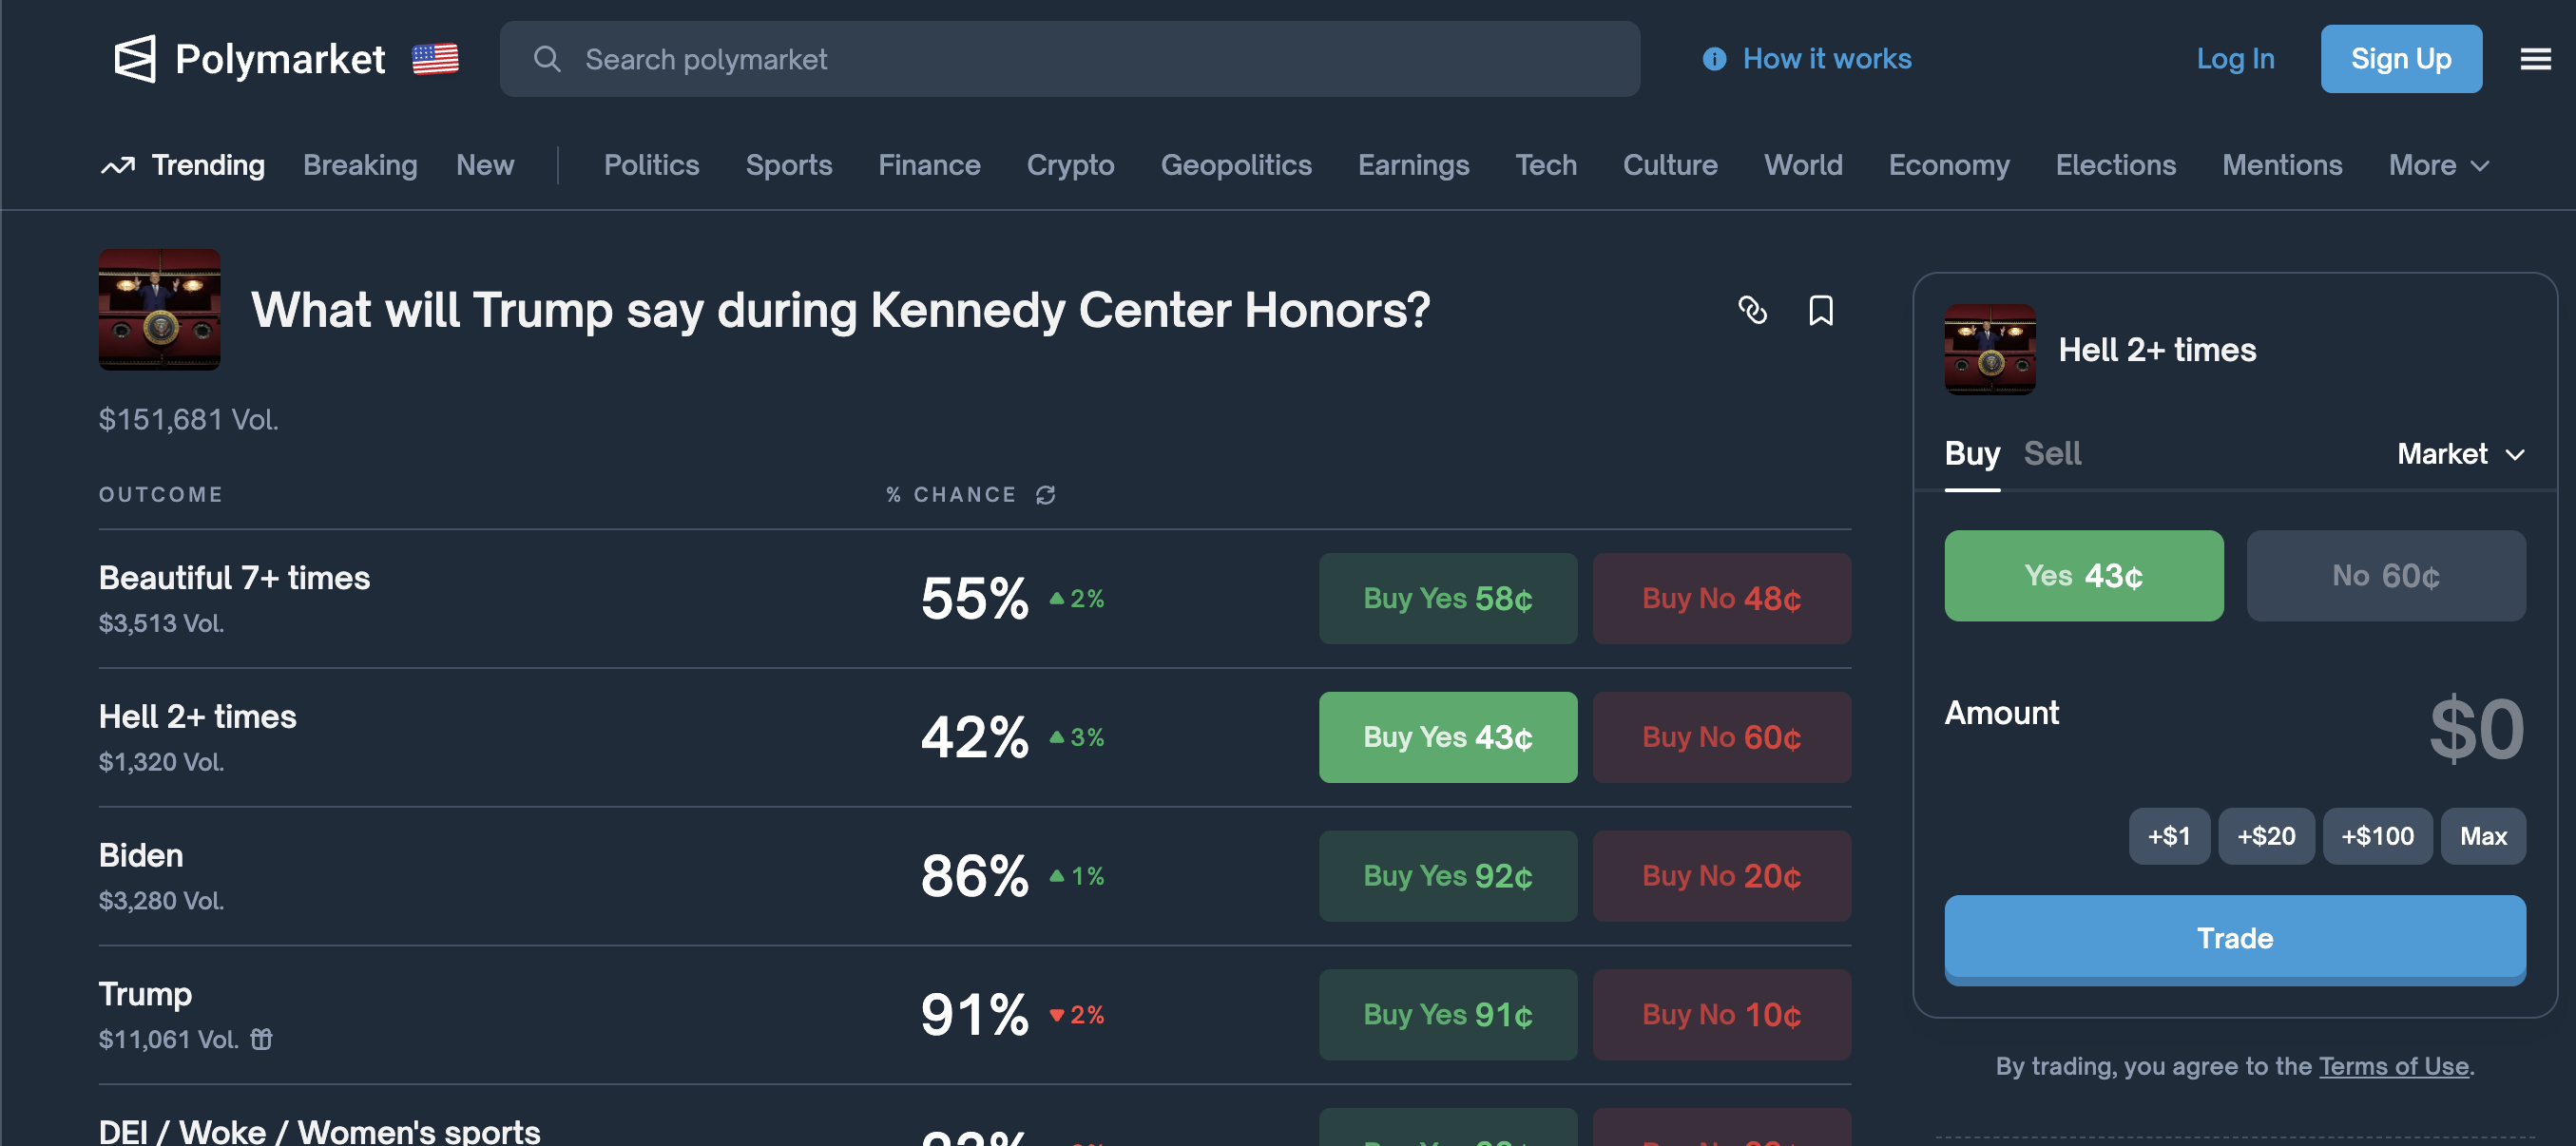

In [1]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Add src to path
project_root = Path("../../")
sys.path.append(str(project_root))

from src.filtering_corpus.speech_corpus import SpeechCorpus

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 6)
sns.set_theme(style="whitegrid")

## 1. Load Data

In [2]:
corpus = SpeechCorpus(data_dir="../../data")
df = corpus.get_full_speeches(text_columns=["clean_v1"])
# If clean_v1 is missing, fallback might be needed, but assuming it exists based on context
if 'clean_v1' not in df.columns and 'text' in df.columns:
    df['clean_v1'] = df['text'] # Fallback
    
# Filter for speeches after 2015 (2016 onwards)
df = df[df['date'].dt.year > 2015].copy()

print(f"Loaded {len(df)} speeches.")
df['date'] = pd.to_datetime(df['date'])
# Exclude "Religious" category
if 'categories' in df.columns:
    df = df[~df['categories'].str.contains('Religious', case=False, na=False)].copy()

print(f"After excluding Religious, speeches: {len(df)}")

# Search for "Kennedy Center Honors"
kennedy = df[df['title'].str.contains('Kennedy', case=False, na=False) | df['title'].str.contains('Honors', case=False, na=False)]
print(f"Found {len(kennedy)} speeches matching 'Kennedy' or 'Honors':")
print(kennedy[['date', 'title', 'categories']])


Loaded 808 speeches.
After excluding Religious, speeches: 807
Found 2 speeches matching 'Kennedy' or 'Honors':
          date                                              title  \
16  2025-05-19  Speech: Donald Trump Attends a Kennedy Center ...   
339 2020-05-30  Speech: Donald Trump Delivers Address at the K...   

                                            categories  
16   ["Government", "Arts, Culture, Entertainment a...  
339      ["Space Programme", "Science and Technology"]  


## 2. Define Keywords and Counting Function

In [3]:
def count_word_occurrences(text, word):
    if not isinstance(text, str):
        return 0
    # Simple case-insensitive match
    return len(re.findall(r'\b' + re.escape(word) + r'\b', text, re.IGNORECASE))

df['beautiful_count'] = df['clean_v1'].apply(lambda x: count_word_occurrences(str(x), "beautiful"))
df['hell_count'] = df['clean_v1'].apply(lambda x: count_word_occurrences(str(x), "hell"))

## 3. Create Filtering Subsets

In [4]:
# Filter 1: December Speeches
december_speeches = df[df['date'].dt.month == 12].copy()

# Filter 2: Non-Rally Speeches
non_rally_speeches = df[df['is_rally'] == False].copy()

# Filter 3: Category match for Ceremony
def is_ceremony(cats):
    if not isinstance(cats, str):
        return False
    cats_lower = cats.lower()
    return "ceremony" in cats_lower

ceremony_speeches = df[df['categories'].apply(is_ceremony)].copy()

# Filter 4: Recent years (Last 3 years)
recent_speeches = df[df['date'].dt.year >= 2022].copy()

# Filter 5: Category match for Arts, Culture
def is_arts_culture(cats):
    if not isinstance(cats, str):
        return False
    cats_lower = cats.lower()
    return "arts" in cats_lower or "culture" in cats_lower

arts_culture_speeches = df[df['categories'].apply(is_arts_culture)].copy()

# Analysis titles
def is_title_relevant(title):
    if not isinstance(title, str):
        return False
    title_lower = title.lower()
    return "kennedy" in title_lower or "center" in title_lower or "honors" in title_lower

title_relevant_speeches = df[df['title'].apply(is_title_relevant)].copy()

print(f"December Speeches: {len(december_speeches)}")
print(f"Non-Rally Speeches: {len(non_rally_speeches)}")
print(f"Ceremony Speeches: {len(ceremony_speeches)}")
print(f"Recent Speeches: {len(recent_speeches)}")
print(f"Arts/Culture Speeches: {len(arts_culture_speeches)}")
print(f"Title Relevant Speeches: {len(title_relevant_speeches)}")

# Displaying titles of potentially relevant speeches
print("\nRelevant Titles:")
print(title_relevant_speeches['title'].unique())

December Speeches: 19
Non-Rally Speeches: 441
Ceremony Speeches: 0
Recent Speeches: 256


## 4. Probability Analysis

In [5]:
def calculate_stats(dataframe, column, threshold):
    stats = {
        'mean': dataframe[column].mean(),
        'median': dataframe[column].median(),
        'max': dataframe[column].max(),
        'prob_threshold_plus': (dataframe[column] >= threshold).mean()
    }
    return stats

subsets = {
    'All Speeches': df,
    'December': december_speeches,
    'Non-Rally': non_rally_speeches,
    'Ceremony Speeches': ceremony_speeches,
    'Recent (2022+)': recent_speeches,
    'Arts/Culture': arts_culture_speeches,
    'Title Relevant': title_relevant_speeches
}

results_beautiful = []
results_hell = []

for name, subset in subsets.items():
    if len(subset) > 0:
        s_b = calculate_stats(subset, 'beautiful_count', 7)
        s_b['subset'] = name
        results_beautiful.append(s_b)
        
        s_h = calculate_stats(subset, 'hell_count', 2)
        s_h['subset'] = name
        results_hell.append(s_h)

res_beautiful_df = pd.DataFrame(results_beautiful).set_index('subset')
res_hell_df = pd.DataFrame(results_hell).set_index('subset')

In [6]:
print("Stats for 'Beautiful' (Target: 7+)")
display(res_beautiful_df.style.format("{:.2f}"))

Stats for 'Beautiful' (Target: 7+)


,mean,median,max,prob_threshold_plus
subset,,,,
All Speeches,7.14,6.00,33.00,0.45
December,7.21,7.00,20.00,0.53
Non-Rally,5.03,4.00,33.00,0.28
Recent (2022+),12.19,11.50,28.00,0.83


In [7]:
print("Stats for 'Hell' (Target: 2+)")
display(res_hell_df.style.format("{:.2f}"))

Stats for 'Hell' (Target: 2+)


,mean,median,max,prob_threshold_plus
subset,,,,
All Speeches,6.62,5.00,43.00,0.73
December,7.21,7.00,14.00,0.79
Non-Rally,3.89,2.00,36.00,0.57
Recent (2022+),11.64,11.00,43.00,0.93


## 5. Visualizations

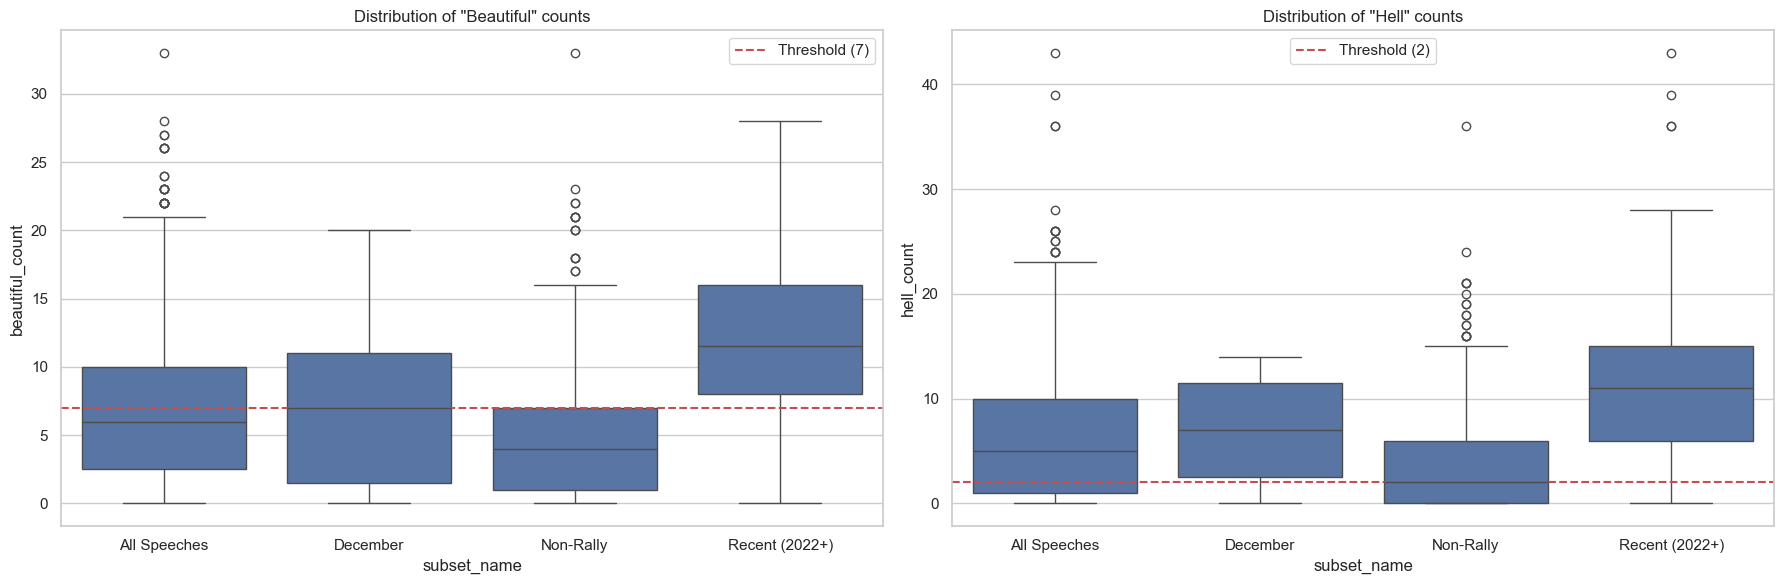

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

plot_data = []
for name, subset in subsets.items():
    subset = subset.copy()
    subset['subset_name'] = name
    plot_data.append(subset[['subset_name', 'beautiful_count', 'hell_count']])
    
plot_df = pd.concat(plot_data)

sns.boxplot(x='subset_name', y='beautiful_count', data=plot_df, ax=ax[0])
ax[0].axhline(y=7, color='r', linestyle='--', label='Threshold (7)')
ax[0].set_title('Distribution of "Beautiful" counts')
ax[0].legend()

sns.boxplot(x='subset_name', y='hell_count', data=plot_df, ax=ax[1])
ax[1].axhline(y=2, color='r', linestyle='--', label='Threshold (2)')
ax[1].set_title('Distribution of "Hell" counts')
ax[1].legend()

plt.tight_layout()
plt.show()

## 6. Time Series Analysis (Grouped by Month/Year)

/var/folders/c1/0gryp8dd5fg4sff058v3gb4m0000gn/T/ipykernel_9589/4097692948.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_resampled = df.set_index('date').resample('M')[['beautiful_count', 'hell_count']].mean()


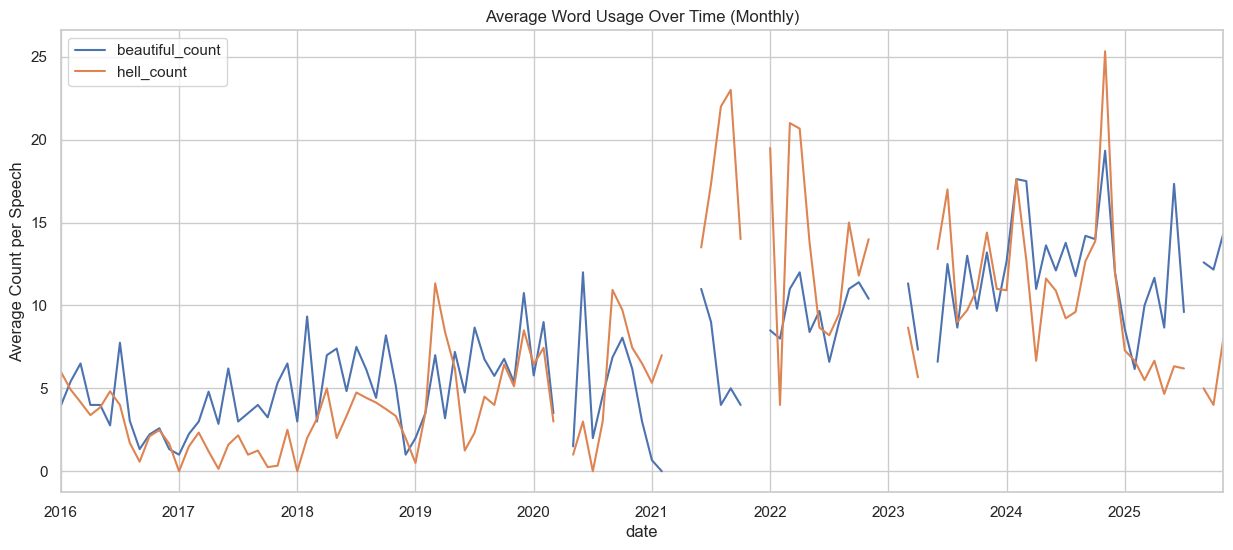

In [9]:
# Resample by month to see trends
df_resampled = df.set_index('date').resample('M')[['beautiful_count', 'hell_count']].mean()

fig, ax = plt.subplots(figsize=(15, 6))
df_resampled.plot(ax=ax)
ax.set_title('Average Word Usage Over Time (Monthly)')
ax.set_ylabel('Average Count per Speech')
plt.show()